In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import lffuncs
import reionizer
from astropy.cosmology import Planck15
import astropy.units as u
import matplotlib as mpl
from astropy.convolution import Gaussian1DKernel, convolve
import kmos_tools as KT

mpl.rcParams['font.size'] = 16

import emcee
import corner

from palettable.colorbrewer.qualitative import Dark2_7
from palettable.colorbrewer.qualitative import Set1_7
from palettable.tableau import Tableau_10
# col = Dark2_7.hex_colors
col2 = Tableau_10.hex_colors
# col = Set1_7.hex_colors
from palettable.cubehelix import cubehelix3_16
col = cubehelix3_16.hex_colors

import logging

logging.getLogger().setLevel(logging.WARNING)

/home/cmason/Documents/Research/LyaInference/LyaInference/reionizer/utils.py:12: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/cmason/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/cmason/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/cmason/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/cmason/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/cmason/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py",

module://ipykernel.pylab.backend_inline


/home/cmason/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


[DEBUG] loaded rc file /home/cmason/Documents/Research/code/matplotlibrc


# Calculations for Binospec proposal

- How many sources do we need?
- What is the flux limit?
- What is the required S/N per resolution element?
- What is the required exposure time?

Binospec specs
Grating lines/mm	|Order	|Blaze angle	|Angle of incidence	|Anamorph Demag.	|Coverage (A)	|Dispersion (A/pixel)	|Pixels per 1'' slit	|Resolution in 1'' slit
---|---|---|---|---|---|---|---
600	|1	|16.0	|38.5	|1.27	|7255-9750	|0.61	|3.20	|4360

In [217]:
c = 3.E5 # km/s

def fLya_from_Muv(Muv, z, returnW=False):
    """
    Generate flya from Muv. Do this lots of times
    """    
    # Use Gronke+15 p(W | Muv)
    Wtab = np.linspace(0., 500., 500.)
    CDF_pW_Muv = reionizer.CDF_W0_DijkstraWyithe_emission(Muv, W=Wtab, z=z)
    Wdraw = reionizer.sample_from_cdf(cdf=CDF_pW_Muv, x=Wtab, plot=False, Ndraw=1)[0]                    
    
    muv = survey.m_from_M(Muv, z=z)
    f   = W_to_flux(Wdraw, m=muv, z=z)
    
    if returnW:
        return Wdraw
    else:
        return f
    
def W_to_flux(W, m, z=7.):
    f0  = 3.631E-20
    c   = 3E5 #km/s into A/s
    c_A = c * 1E13
    L0  = 1216.
    flux = W * f0 * 10**(-0.4*m) * c_A/L0**2./(1.+z)
    return flux

def trunc_gauss(x, mu, sigma, trunc=0., pos=True):
    gauss = np.exp(-0.5*((x-mu)/sigma)**2.)/np.sqrt(2.*np.pi)/sigma
    
    if pos:
        gauss[x < trunc] = 0.
    else:
        gauss[x > trunc] = 0.
   
    gauss /= np.trapz(gauss, x)
    return gauss

def lya_profile(x, Ftot, mu0, FWHM_A=10., red2blue_sep=10., red2blue_flux=2., FWHM_res_A=1.8):
    """
    2 Gaussian Lya profile
    """
    mu_blue = mu0 - red2blue_sep/2.
    mu_red  = mu0 + red2blue_sep/2.  
    sigma_res = FWHM_res_A/2.355
    sigma     = np.sqrt((FWHM_A/2.355)**2. + sigma_res**2.)
    sigma     = FWHM_A/2.355
    
    # stddev must be in pixels
    dlambda = np.median(np.gradient(x))
    sigma_res_pix = sigma_res/dlambda
    
    gauss_instr = Gaussian1DKernel(stddev=sigma_res_pix)
    
    line_blue = trunc_gauss(x, mu=mu_blue, sigma=sigma, trunc=mu_blue + red2blue_sep/4., pos=False)
    line_red  = trunc_gauss(x, mu=mu_red,  sigma=sigma, trunc=mu_red - red2blue_sep/4.)

    line_profile = line_blue + red2blue_flux * line_red
#     gauss_smooth = Gaussian1DKernel(stddev=3*np.median(np.gradient(x)))
#     line_profile_smooth = convolve(line_profile, gauss_smooth)

    line_profile_conv = convolve(line_profile, gauss_instr)
    line_profile_conv /= np.trapz(line_profile_conv, x)
    
    return Ftot * line_profile_conv

In [120]:
def lnlike(theta, x, f, f_err):
    Ftot, mu0, FWHM_A, red2blue_sep, red2blue_flux = theta
    f_model = lya_profile(x, Ftot, mu0, FWHM_A=FWHM_A, red2blue_sep=red2blue_sep, red2blue_flux=red2blue_flux, FWHM_res_A=1.8)
    inv_sigma2 = 1./f_err**2.
    return -0.5*(np.nansum((f - f_model)**2.*inv_sigma2 - np.log(inv_sigma2)))

def lnprior(theta):
    Ftot, mu0, FWHM_A, red2blue_sep, red2blue_flux = theta
    if Ftot > 0. and 7255. < mu0 < 9750. and 0. < FWHM_A < 20.0 and \
        0. < red2blue_sep < 20.0 and 0.1 < red2blue_flux < 10.0:
        return 0.0
    return -np.inf

def lnprob(theta, x, f, f_err):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, f, f_err)

FWHM = 3.3 pixels, peak_sep = 3.3 pixels
1.83486238532
total line width = 16.3 pixels
Total S/N = 29.34923050211723
Total S/N = 16.305128056731792
Total S/N = 32.610256113463585
Total S/N = 48.91538417019538
[-1125.  1125.]


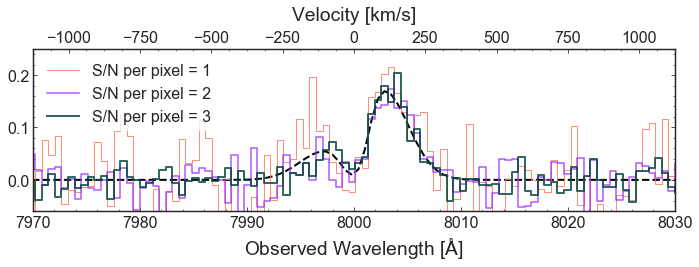

In [218]:
# Binospec
pixel_A = 0.61
R       = 4360.

# X-shooter
# pixel_A = 0.18
# R       = 5000. #xshooter

x = np.arange(7255, 9750, pixel_A)

mu0    = 8000.
FWHM_kms = 200.
FWHM_A   = mu0 * FWHM_kms/c
peak_sep_kms = FWHM_kms
peak_sep_A   = mu0 * peak_sep_kms/c
print 'FWHM = %.1f pixels, peak_sep = %.1f pixels' % (FWHM_A * pixel_A, peak_sep_A * pixel_A)
R_FWHM_A= mu0/R
print R_FWHM_A


total_line_width_A = np.sqrt((4.*FWHM_A + peak_sep_A)**2. + R_FWHM_A**2.)
print 'total line width = %.1f pixels' % (total_line_width_A * pixel_A)

StoN_pix = 1.8
Ftot     = StoN_pix * total_line_width_A * pixel_A
print 'Total S/N =',Ftot

noise_scale = 1.
noise    = np.random.normal(loc=0., scale=noise_scale, size=len(x))
lya_line = lya_profile(x=x, Ftot=Ftot, mu0=mu0, FWHM_A=FWHM_A, FWHM_res_A=R_FWHM_A,
                       red2blue_sep=peak_sep_A, red2blue_flux=3.)



plt.figure(figsize=(10,4))
ax1 = plt.subplot()
StoN_pix_tab = [1., 2., 3.,]
for i,StoN_pix in enumerate(StoN_pix_tab):
    Ftot     = StoN_pix * total_line_width_A * pixel_A
    print 'Total S/N =',Ftot

    lya_line_test = lya_profile(x=x, Ftot=1., mu0=mu0, FWHM_A=FWHM_A, FWHM_res_A=R_FWHM_A,
                           red2blue_sep=peak_sep_A, red2blue_flux=3.)
    
    noise_test  = np.random.normal(loc=0., scale=1./Ftot, size=len(x))

    if i==0:
        ax1.plot(x, lya_line_test, c='k', lw=2, ls='dashed')

    ax1.plot(x, lya_line_test + noise_test, c=col[10-4*i], lw=1+i/2., alpha=0.8,
             drawstyle='steps-mid', label='S/N per pixel = %.0f' % StoN_pix)
    
ax1.legend(loc='upper left', frameon=True)

wave_clip = 30
ax1.set_xlim(mu0 - wave_clip, mu0+wave_clip)
ax1.set_ylim(-0.06, 0.25)

ax2 = ax1.twiny()
ax2.plot(x, lya_line_test, c='k', lw=2, ls='dashed')
print c*(np.array(ax1.get_xlim())-mu0)/mu0
ax2.set_xlim(c*(np.array(ax1.get_xlim())-mu0)/mu0)

ax1.set_xlabel('Observed Wavelength [$\mathrm{\AA}$]')
ax2.set_xlabel('Velocity [km/s]', labelpad=10)
plt.ylabel('Flux density [arb. units]')

plt.tight_layout()
plt.savefig('lineshape.pdf', bbox_inches='tight')

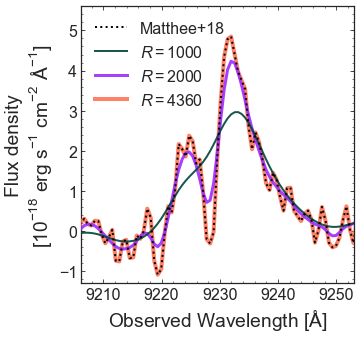

In [246]:
cola1 = np.genfromtxt('targets/xshoot_cola1_LASD.cat', names=True)
z = 6.593
mu0 = 1216. * (1.+z)
def convolve_R(wave, flux, R=1000., mu=mu0):
    
    FWHM_res_A    = mu0/R
    FWHM_Xshooter = mu0/5000.
    sigma_res  = (FWHM_res_A-FWHM_Xshooter)/2.355

    # stddev must be in pixels
    dlambda       = np.median(np.gradient(wave))
    sigma_res_pix = sigma_res/dlambda

    gauss_instr = Gaussian1DKernel(stddev=sigma_res_pix)
    flux_conv = convolve(flux, gauss_instr)
#     flux_conv /= np.trapz(flux_conv, wave)
    
    return flux_conv

R_tab = [1340., 2700., 4360.]
R_tab = [1000., 2000., 4360.]


labels=['Binospec 270 l/mm', 'JWST NIRSpec', 'Binospec 600 l/mm']

plt.figure(figsize=(5.3,5))
plt.plot(cola1['observed_wavelength'], cola1['fluxdensity']/100., 
         c='k', ls='dotted', lw=2, label='Matthee+18', zorder=10)
for rr, R in enumerate(R_tab):
    plt.plot(cola1['observed_wavelength'], 
             convolve_R(cola1['observed_wavelength'], cola1['fluxdensity']/100., R=R), 
             label='$R=%.0f$' % R, lw=rr+2, alpha=0.9, c=col[2+4*rr], zorder=9-rr)

plt.xlabel('Observed Wavelength [$\mathrm{\AA}$]')
# plt.xlabel('Velocity [km/s]', labelpad=20)
plt.ylabel('Flux density\n'+r'[$10^{-18}$ erg s$^{-1}$ cm$^{-2}$ $\mathrm{\AA}^{-1}$]')
plt.legend(loc='upper left')


plt.xlim(mu0-27.,mu0+20.)
plt.ylim(-1.3,5.6)

plt.tight_layout()
plt.savefig('resolution.pdf', bbox_inches='tight')

FWHM = 1.6 pixels, peak_sep = 1.6 pixels
8.0
3.2
2.0
0.8


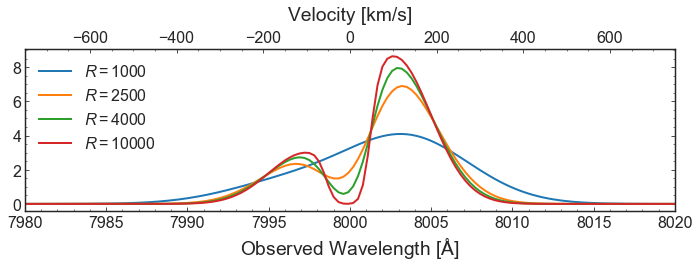

In [146]:
# Resolution plot
# Binospec
pixel_A = 0.3
R       = 4360.

x = np.arange(7255, 9750, pixel_A)

mu0     = 8000.
FWHM_kms = 200.
FWHM_A   = mu0 * FWHM_kms/c
peak_sep_kms = FWHM_kms
peak_sep_A   = mu0 * peak_sep_kms/c
print 'FWHM = %.1f pixels, peak_sep = %.1f pixels' % (FWHM_A * pixel_A, peak_sep_A * pixel_A)


plt.figure(figsize=(10,4))
ax1 = plt.subplot()

for R in [1000., 2500., 4000., 10000.]:
    R_FWHM_A= mu0/R
    print R_FWHM_A
    lya_line = lya_profile(x=x, Ftot=Ftot, mu0=mu0, FWHM_A=FWHM_A, FWHM_res_A=R_FWHM_A,
                           red2blue_sep=peak_sep_A, red2blue_flux=3.)

    ax1.plot(x, lya_line, lw=2, label='$R=%.0f$' % R)

ax1.legend(loc='upper left', frameon=True)

wave_clip = 20
ax1.set_xlim(mu0 - wave_clip, mu0+wave_clip)
# ax1.set_ylim(-0.06, 0.2)

ax2 = ax1.twiny()
ax2.set_xlim(c*(np.array(ax1.get_xlim())-mu0)/mu0)

ax1.set_xlabel('Observed Wavelength [$\mathrm{\AA}$]')
ax2.set_xlabel('Velocity [km/s]', labelpad=10)
plt.ylabel('Flux density [arb. units]')

plt.tight_layout()
plt.savefig('lineshape_R.pdf', bbox_inches='tight')

In [307]:
# Fit line
theta_init = [Ftot, mu0, FWHM_A, peak_sep_A, 3.]
theta_params = ['Ftot', 'mu', 'FWHM [A]', 'peak sep [A]', 'Fred/Fblue']
print theta_init

ndim, nwalkers = len(theta_init), 50
pos = [theta_init + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, lya_line+noise, noise))

[29.34923050211723, 8000.0, 5.333333333333333, 5.333333333333333, 3.0]


In [308]:
sampler.run_mcmc(pos, 500)

(array([[  2.88847492e+01,   8.00007510e+03,   5.81689638e+00,
           4.51255082e+00,   4.06848936e+00],
        [  3.06943950e+01,   8.00036043e+03,   5.88577930e+00,
           4.84524447e+00,   3.90879770e+00],
        [  3.21846432e+01,   7.99998431e+03,   5.94404131e+00,
           4.96731445e+00,   2.96903847e+00],
        [  3.03695321e+01,   8.00029092e+03,   5.81109215e+00,
           4.70488300e+00,   3.43333185e+00],
        [  3.05620334e+01,   8.00051119e+03,   5.72854350e+00,
           4.31505233e+00,   3.16332166e+00],
        [  2.92410736e+01,   7.99966584e+03,   5.40730716e+00,
           5.49376795e+00,   2.87558036e+00],
        [  2.78711495e+01,   7.99979087e+03,   5.88809349e+00,
           5.10372542e+00,   5.53908595e+00],
        [  3.15104934e+01,   8.00011293e+03,   5.87020530e+00,
           4.89832699e+00,   3.18127244e+00],
        [  3.09821917e+01,   8.00028736e+03,   5.74858228e+00,
           4.79402234e+00,   3.15164340e+00],
        [  3.191310

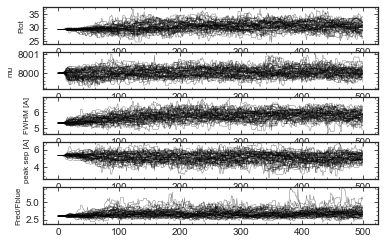

In [309]:
fig, ax = plt.subplots(ndim,1)
ax = ax.ravel()
for i in range(ndim):
    ax[i].plot(sampler.chain[:,:,i].T, c='k', lw=0.5, alpha=0.5)
    ax[i].set_ylabel(theta_params[i], fontsize=8)
# fig.tight_layout()

[DEBUG] backend module://ipykernel.pylab.backend_inline version unknown


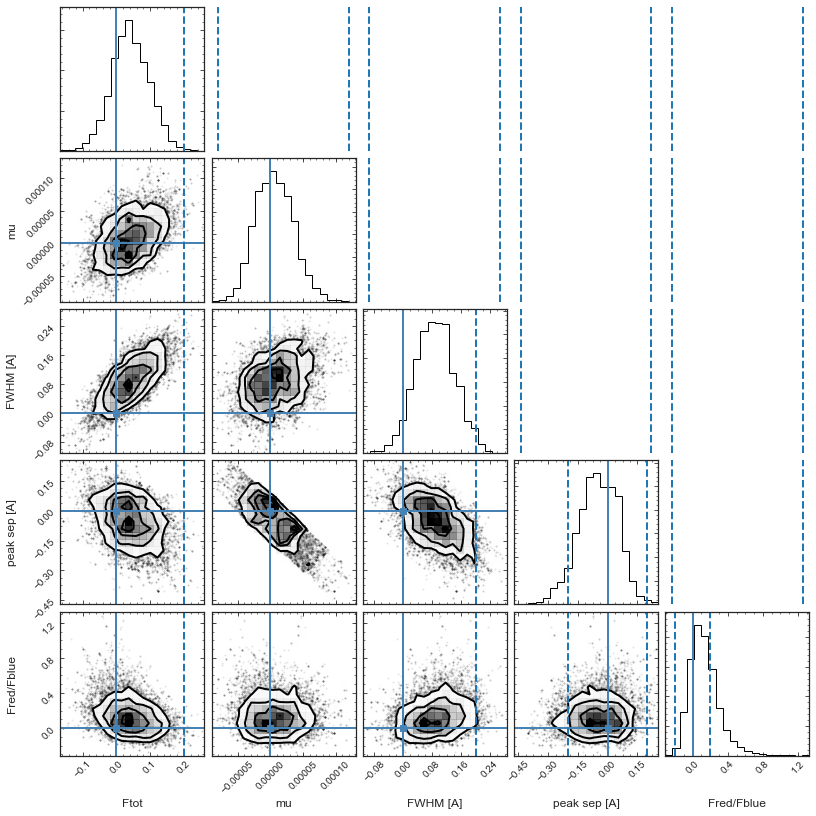

In [310]:
%matplotlib inline
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
truths = [0., 0., 0., 0., 0.]

fractional_error = (samples-np.array(theta_init))/np.array(theta_init)
fig = corner.corner(fractional_error, labels=theta_params,
                      truths=truths, hist_kwargs={'lw':1})
for ax in fig.axes:
    ax.axvline( 0.2, ls='dashed')
    ax.axvline(-0.2, ls='dashed')

fig.savefig('params.png')
plt.show()

In [122]:
# Set up survey class
survey = lffuncs.SurveyForecast(z=7.)
survey.schechter_fits()

# Draw LBGs from LF

Text(0,0.5,'N')

/anaconda2/lib/python2.7/site-packages/matplotlib/mathtext.py:834: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


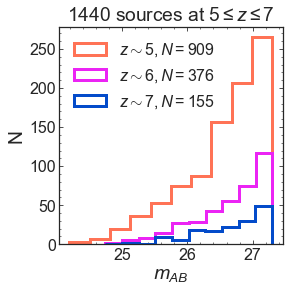

In [123]:
# Total number of sources in survey area (based on average number density)
# Draw from LF to get magnitudes

area_sqarcmin = 133. # total GOODS-N
mmin = 27.3

z_tab = [5., 6., 7.]

plt.figure(figsize=(4,4))

draw_Muv = {}
draw_m   = {}
for zz,z in enumerate(z_tab):
    draw_Muv[z] = survey.draw_in_area(area_sqarcmin=area_sqarcmin, z=z, mmin=mmin, 
                                drawCDF=True, returnM=True)
    draw_m[z]   = survey.m_from_M(MAB=draw_Muv[z], z=z)
    
    plt.hist(draw_m[z], histtype='step', lw=3, color=col[10-3*zz],
             label='$z\sim%.0f, N=%i$' % (z, len(draw_m[z])))

Ntot = np.array([item for sublist in np.array(draw_m.values()) for item in sublist]).size
plt.title('%i sources at $5\leq z \leq 7$' % Ntot)
plt.legend(loc='upper left')
plt.xlabel('$m_{AB}$')
plt.ylabel('N')

# Draw W for each LBG

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  


Blank Field S/N>30: z=5, Ngals >= 2e-17: 141, non-detections: 768
Blank Field S/N>5: z=5, Ngals >= 3e-18: 466, non-detections: 443
Blank Field S/N>30: z=6, Ngals >= 2e-17: 45, non-detections: 331
Blank Field S/N>5: z=6, Ngals >= 3e-18: 180, non-detections: 196
Blank Field S/N>30: z=7, Ngals >= 2e-17: 16, non-detections: 139
Blank Field S/N>5: z=7, Ngals >= 3e-18: 75, non-detections: 80
{5.0: 141, 6.0: 45, 7.0: 16}
721


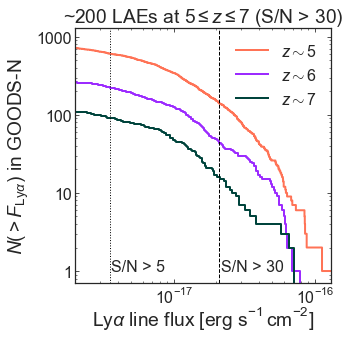

In [287]:
draw_flux = {}
fscale = 1. #E17
flim   = 2.1e-17 / fscale
# flim   = 5.e-17 / fscale

plt.figure(figsize=(5,5))

detections, nondetections = {}, {}
detections_5sigma, nondetections_5sigma = {}, {}
for zz, z in enumerate(z_tab):
    
    draw_flux[z] = fscale * np.array([fLya_from_Muv(Muv=Muv, z=z) for Muv in draw_Muv[z]])
    
    fsample      = draw_flux[z]
    fsample_sort = np.sort(fsample) #[::Nsample]

    fsample_flux_i = np.concatenate([fsample_sort[::-1], fsample_sort[[0]]])
    fsample_Ncum_i = np.arange(fsample_sort.size+1)

    detections[z]    = len(fsample_sort[fsample_sort > flim])
    nondetections[z] = len(fsample_sort) - detections[z]
    print 'Blank Field S/N>30: z=%.0f, Ngals >= %.e: %i, non-detections: %i' % (z, flim, detections[z], nondetections[z])

    detections_5sigma[z]    = len(fsample_sort[fsample_sort > flim/6.]) - detections[z]
    nondetections_5sigma[z] = len(fsample_sort) - detections_5sigma[z]
    print 'Blank Field S/N>5: z=%.0f, Ngals >= %.e: %i, non-detections: %i' % (z, flim/6., detections_5sigma[z], nondetections_5sigma[z])


    plt.semilogy(fsample_flux_i, fsample_Ncum_i, color=col[10-4*zz],
                 drawstyle='steps', label=r'$z\sim%.0f$' % z)

#     plt.hist(draw_flux[z]*1e17, histtype='step', lw=3, label='$z\sim%.0f$' % (z))

# Ntot = np.array([item for sublist in np.array(draw_m.values()) for item in sublist]).size
# plt.title('%i sources at $5\leq z \leq 7$' % Ntot)
print detections

Ntot = np.sum(detections.values())
plt.title('~%.0f LAEs at $5\leq z \leq 7$ (S/N > 30)' % (np.rint(Ntot/10.)*10.))

Ntot_5sigma = np.sum(detections_5sigma.values())
print Ntot_5sigma
# plt.title('%i detected LAEs at $5\leq z \leq 7$ (S/N > 30)' % Ntot)

plt.axvline(x=flim, ls='dashed', lw=1, c='k')
plt.axvline(x=flim/6., ls='dotted', lw=1, c='k')

plt.annotate('S/N > 5', (1.03*flim/6., 1.))
plt.annotate('S/N > 30', (1.03*flim, 1.))

plt.minorticks_on()
plt.xscale('log')
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))

plt.legend(loc='upper right')
plt.xlabel(r'Ly$\alpha$ line flux [erg s$^{-1}\,$cm$^{-2}$]', labelpad=-2)
plt.ylabel(r'$N(>F_{\mathrm{Ly}\alpha})$ in GOODS-N')

plt.xlim(2e-18, 1.3e-16)
plt.tight_layout()
plt.savefig('N_LAEs.pdf', bbox_inches='tight')

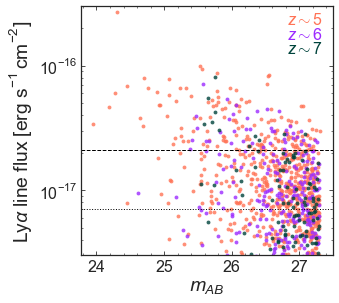

In [10]:
plt.figure(figsize=(5,4.5))

for zz, z in enumerate(z_tab):

    plt.scatter(draw_m[z], draw_flux[z], color=col[10-4*zz],
                 label=r'$z\sim%.0f$' % z, alpha=0.8, s=15)
    
    plt.annotate(r'$z\sim%.0f$' % z, xy=(0.96,0.93-zz*0.06), xycoords='axes fraction', 
                 ha='right', color=col[10-4*zz], weight='bold')

# plt.legend(numpoints=1, handletextpad=0.01)
plt.axhline(y=flim, ls='dashed', lw=1, c='k')
plt.axhline(y=flim/3., ls='dotted', lw=1, c='k')
plt.yscale('log')
plt.ylim(3e-18, 3e-16)

plt.xlabel('$m_{AB}$')
plt.ylabel(r'Ly$\alpha$ line flux [erg s$^{-1}\,$cm$^{-2}$]')

plt.tight_layout()
plt.savefig('mAB_fLya.pdf', bbox_inches='tight')

909 464
376 144
155 56


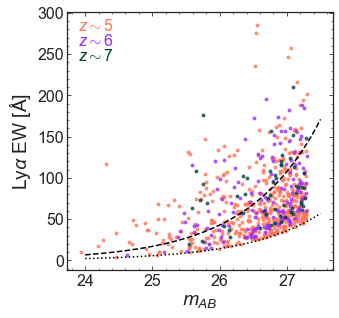

In [11]:
plt.figure(figsize=(5,4.7))

m_tab = np.linspace(24.,27.5)
fcont_all = KT.f_cont(m_tab, wave=1216*(1.+5.))
EW_all    = flim/fcont_all/(1.+5.)
plt.plot(m_tab, EW_all, c='k', ls='dashed', lw=1.5, )
plt.plot(m_tab, EW_all/3., c='k', ls='dotted', lw=1.5, )


for zz, z in enumerate(z_tab):
    
    fcont = KT.f_cont(draw_m[z], wave=1216*(1.+z))

    W = draw_flux[z]/fcont/(1.+z)
    
    EW = W[draw_flux[z] > flim/3]
    print len(W), len(EW)
    
    plt.scatter(draw_m[z][draw_flux[z] > flim/3], EW, color=col[10-4*zz],
                 label=r'$z\sim%.0f$' % z, alpha=0.8, s=15)
    
    plt.annotate(r'$z\sim%.0f$' % z, xy=(0.04,0.93-zz*0.06), xycoords='axes fraction', 
                 ha='left', color=col[10-4*zz], weight='bold')

# plt.legend(numpoints=1, handletextpad=0.01)
# plt.axhline(y=flim, ls='dashed', lw=1, c='k')
# plt.axhline(y=flim/3., ls='dotted', lw=1, c='k')
# plt.yscale('log')
# plt.ylim(3e-18, 3e-16)

plt.xlabel('$m_{AB}$')
plt.ylabel(r'Ly$\alpha$ EW [$\mathrm{\AA}$]')

plt.tight_layout()
plt.savefig('mAB_EWLya.pdf', bbox_inches='tight')

# S/N ratios

Daniel Eisenstein's proposal:

4 hours: 1 sigma noise = 1.4e-18 erg/s/cm^2

**We want S/N = 30**

$$\sigma(t) = 1.4\times10^{-18} \sqrt{4/t}$$

7e-19
30sigma flux limit in 16 hours = 2.1000000000000002e-17


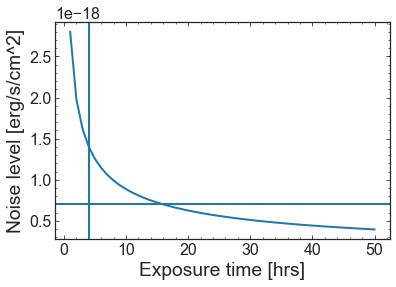

In [12]:
t = np.linspace(1, 50.)
def N_t(t):
    return 1.4e-18*np.sqrt(4.)/np.sqrt(t)
    
plt.plot(t, N_t(t))
plt.axvline(4.)
plt.axhline(N_t(16.))

plt.xlabel('Exposure time [hrs]')
plt.ylabel('Noise level [erg/s/cm^2]')

print N_t(16.)
# We want S/N > 30
print '30sigma flux limit in 16 hours =',N_t(16.) * 30.

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in power


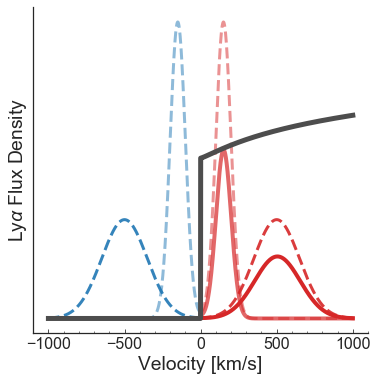

In [97]:
# Nice double-peak cartoon

# Gaussian line shape
def J(v, vcenter, vmin=0., sigma=200.):
    """
    Double peaked daussian line shape
    """
    line = np.exp(-0.5*((v - vcenter)/sigma)**2.)/np.sqrt(2.*np.pi) / sigma
    line[v < vmin] = 0.
    line /= np.trapz(line, v)
    return line

def J_double(v, vcenter, sigma=200.):
    """
    Double peaked daussian line shape
    """
    return (np.exp(-0.5*((v - vcenter)/sigma)**2.) + np.exp(-0.5*((v + vcenter)/sigma)**2.))/ 2. /np.sqrt(2.*np.pi) / sigma

def tau(v, vcenter):
    trans = np.log(v**1.2+800)
    trans[v < vcenter] = 0.
    trans /= np.trapz(trans, v)
    return trans


# col = Dark2_7.hex_colors

plt.figure(figsize=(6,6))

xa = np.linspace(-1000, 1000, 2000)
xb = np.linspace(-1000, 0, 1000)
xr = np.linspace(0, 1000, 1000)

trans   = tau(xa, vcenter=0)
trans_r = 620*tau(xr, vcenter=0)
plt.plot(xa, 2.5*trans,  c='0.3', lw=5, alpha=1, zorder=20)

plt.plot(xb, J_double(xb, sigma=50, vcenter=150),  c=col2[0], lw=3, ls='dashed', alpha=0.5)
plt.plot(xr, J_double(xr, sigma=50, vcenter=150),  c=col2[3], lw=3, ls='dashed', alpha=0.5)
plt.plot(xr, trans_r*J_double(xr, sigma=50, vcenter=150),  c=col2[3], lw=4, alpha=0.7, zorder=10)

# plt.plot(xb, J_double(xb, sigma=100, vcenter=300),  c=col2[0], lw=3, ls='dashed', alpha=0.7)
# plt.plot(xr, J_double(xr, sigma=100, vcenter=300),  c=col2[3], lw=3, ls='dashed', alpha=0.7)
# plt.plot(xr, trans_r*J_double(xr, sigma=100, vcenter=300),  c=col2[3], lw=3, alpha=0.7)

plt.plot(xb, J_double(xb, sigma=150, vcenter=500),  c=col2[0], lw=3, ls='dashed', alpha=0.9)
plt.plot(xr, J_double(xr, sigma=150, vcenter=500),  c=col2[3], lw=3, ls='dashed', alpha=0.9)
plt.plot(xr, trans_r*J_double(xr, sigma=150, vcenter=500),  c=col2[3], lw=4, alpha=1. , zorder=10)

plt.xlabel('Velocity [km/s]')
plt.ylabel(r'Ly$\alpha$ Flux Density')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().tick_params(axis='both', which='both', bottom='on', top='off', labelbottom='on', right='off', left='off', labelleft='off')
# plt.axis('off')
plt.savefig('line_profiles_transmission.pdf', bbox_inches='tight')

# How many sources do we need?

- Reionization, need volume wider than a couple of bubbles (>10 Mpc)
    + **GOODS-N is 3-4x bigger than a typical bubble, expect 1-2 clusters**
- ISM properties, enough to say something statistical

In [256]:
Mpc_per_arcmin = u.arcminute / Planck15.arcsec_per_kpc_comoving(z=7.).to(u.arcmin/u.Mpc)

print 10*Mpc_per_arcmin, 15.*Mpc_per_arcmin

25.6636118595 Mpc 38.4954177893 Mpc


In [254]:
((0.3 * u.Mpc / Planck15.kpc_proper_per_arcmin(z=7.).to(u.Mpc/u.arcmin))*Planck15.kpc_comoving_per_arcmin(z=7.)).to(u.Mpc)

<Quantity 2.4 Mpc>

0.14793191810291545


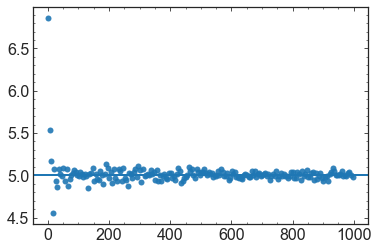

In [284]:
# Draw from distribution

mu  = 5.
sig = 1.

N_tab = np.arange(1,1000,5)
mean  = np.zeros(len(N_tab))
for i,N in enumerate(N_tab):
    dist = np.random.normal(loc=mu, scale=sig, size=N)
    mean[i] = np.mean(dist)
    
plt.scatter(N_tab, mean, alpha=0.9)
plt.axhline(mu)

print np.std(mean/sig)